#Image Classification using VGG16 and ResNet50

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">
    
<strong>Table of Contents:</strong><br />

<p>
    <ul>
        <li>1. Install and Import Dependencies</li>
        <li>
            2. Image Segmentation
        </li>
        <li>
            3. Implement VGG16 from Scratch
        </li>
        <li>
            4. Data Prepration and Training VGG16
        </li>
        <li>5. Evaluating VGG16 and Predicting Labels</li>
        <li>6. Preprocessing and Training ResNet50</li>
        <li>7. Predicting Labels using ResNet50</li>
        <li>8. Conclusion</li>
    </ul>
</p>

# 1. Install and Import Dependencies

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.checkpoint import checkpoint
from torch.utils.data import Dataset
from torchvision import transforms, datasets, models
import torchvision
from fastai.vision.all import *
import os
from tempfile import TemporaryDirectory
import time
import pickle

In [ ]:
paths = {
    'source_train' : os.path.join('/kaggle', 'input', 'cifar-10', 'train.7z'),
    'source_test' : os.path.join('/kaggle', 'input', 'cifar-10', 'test.7z'),
    'dest' : os.path.join('/kaggle', 'working', 'cifar-10'),
    'train' : os.path.join('/kaggle', 'working', 'cifar-10', 'train'),
    'test' : os.path.join('/kaggle', 'working', 'cifar-10', 'test'),
    'trainLabels' : os.path.join('/kaggle', 'input', 'cifar-10', 'trainLabels.csv')
}

In [ ]:
!pip install py7zr

In [ ]:
import py7zr

In [ ]:
def extract_7z_file(archive_path, destination_path):
    with py7zr.SevenZipFile(archive_path, mode='r') as z:
        z.extractall(path=destination_path)

In [ ]:
extract_7z_file(paths['source_train'], paths['dest'])
extract_7z_file(paths['source_test'], paths['dest'])

#2. Image Segmentation

In [ ]:
train_images = os.listdir(paths['train'])
train_images[:10]

['41812.png',
 '21118.png',
 '46544.png',
 '35219.png',
 '24535.png',
 '28595.png',
 '8401.png',
 '24666.png',
 '20296.png',
 '26110.png']

In [ ]:
y_train = pd.read_csv(paths['trainLabels'])
y_train.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [ ]:
labels = y_train['label'].unique()
labels

array(['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship',
       'cat', 'dog', 'airplane'], dtype=object)

In [ ]:
for state in ['train', 'eval']:
    for label in labels:
        if os.path.exists(os.path.join(paths['dest'], 'train', state)) == False:
            os.mkdir(os.path.join(paths['dest'], 'train', state,))

        if os.path.exists(os.path.join(paths['dest'], 'train', state, label)) == False:
            os.mkdir(os.path.join(paths['dest'], 'train', state, label))

In [ ]:
li = []
for item in os.listdir(paths['train']):
    if '.png' not in item:
        li.append(item)
li

['train', 'eval']

In [ ]:
png_files = [item for item in os.listdir(paths['train']) if '.png' in item]
numbers = [int(os.path.splitext(png)[0]) for png in png_files if type(int(os.path.splitext(png)[0])) == int]
numbers.sort()

In [ ]:
X = y_train.copy()
y = X['label'].values
X.drop(['id', 'label'], axis=1, inplace=True)
X['image name'] = [str(num) + '.' + 'png' for num in numbers]
X.shape, y.shape

((50000, 1), (50000,))

In [ ]:
def make_image_grid(labels:np.ndarray, images:list):
    plt.figure(figsize=(10, 10))
    for i in range(32):
        plt.subplot(4, 8, i + 1)
        labeli = labels[i]
        imgi_arr = np.asarray(Image.open(os.path.join(paths['train'], images[i])))
        if imgi_arr.shape == (32, 32, 3):
            pass
        elif imgi_arr.shape == (3, 32, 32):
            imgi_arr = np.transpose(imgi_arr, (1,2,0))
        plt.imshow(imgi_arr)
        plt.title(labeli, size=9, alpha=.8)
        plt.axis('off')

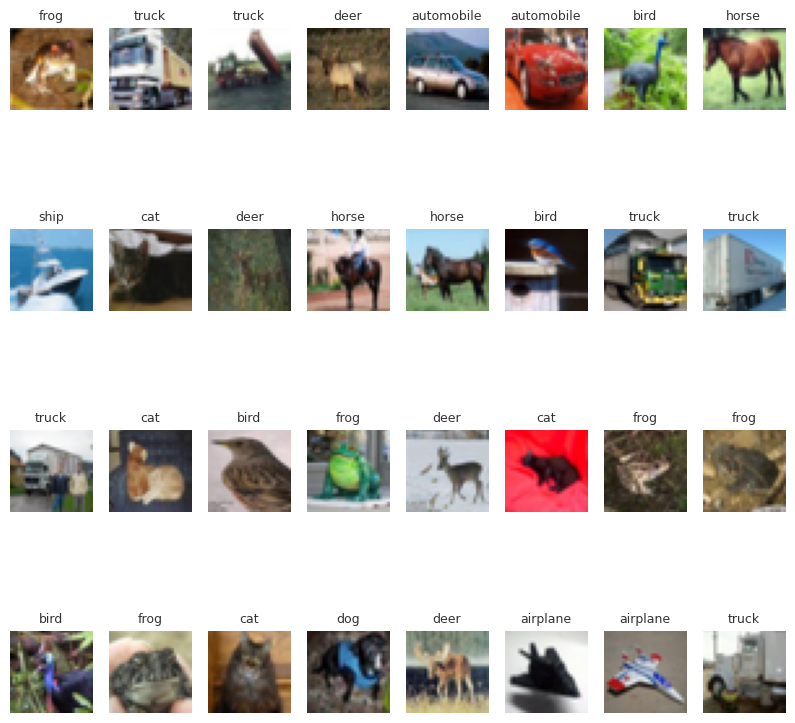

In [ ]:
make_image_grid(y, X['image name'].values.tolist())

In [ ]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, random_state=42, train_size=.8)
print(X_train.shape, y_train.shape)
print(X_eval.shape, y_eval.shape)

(40000, 1) (40000,)
(10000, 1) (10000,)


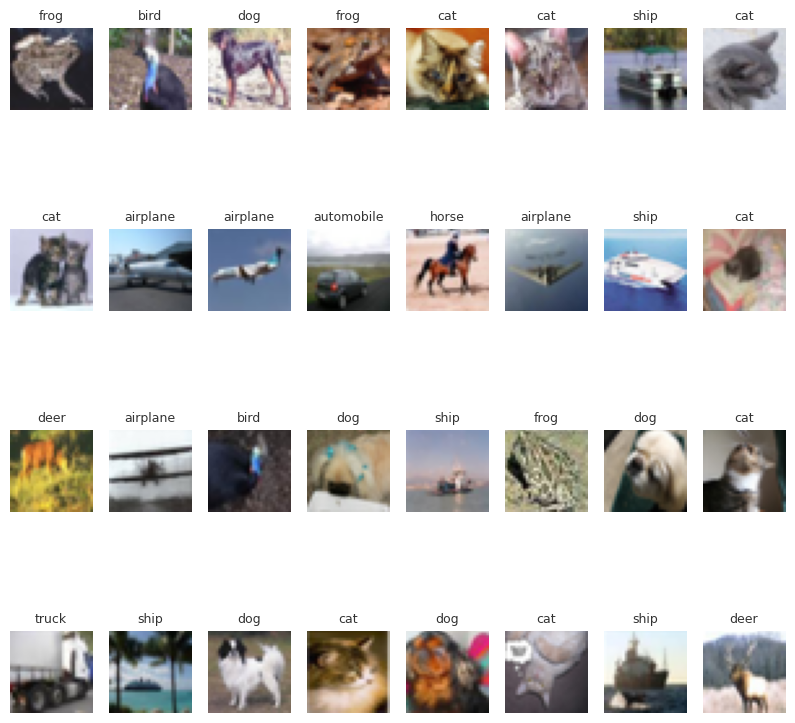

In [ ]:
make_image_grid(y_train, X_train['image name'].values.tolist())

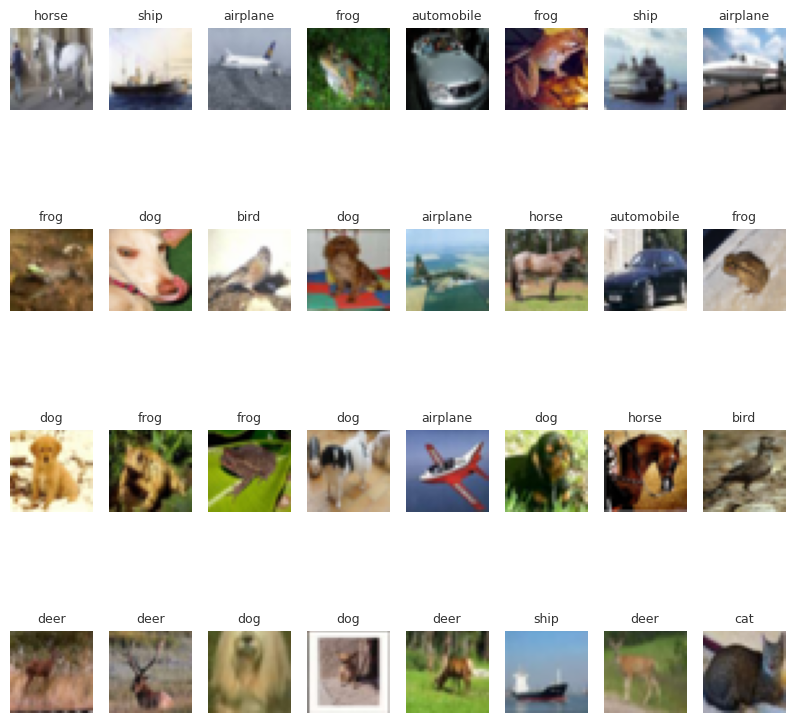

In [ ]:
make_image_grid(y_eval, X_eval['image name'].values.tolist())

In [ ]:
def segment_images(source, state):
    states = {
        'train' : pd.DataFrame({
            'image name' : X_train['image name'].values.tolist(),
            'label' : y_train
        }),
        'eval' : pd.DataFrame({
            'image name' : X_eval['image name'].values.tolist(),
            'label' : y_eval
        })
    }

    for _, row in states[state].iterrows():
        os.rename(os.path.join(source, row['image name']), os.path.join(source, state, row['label'], row['image name']))

segment_images(paths['train'], 'train')
segment_images(paths['train'], 'eval')

#3. Implement VGG16 from Scratch

In [ ]:
VGG16 = [64,64,"M",128,128,"M",256,256,256,"M",512,512,512,"M",512,512,512,"M"]

class VGGNet(nn.Module):
    def __init__(self, inchannel=3, numclass=10):
        super(VGGNet,self).__init__()

        self.inchannel = inchannel
        self.numclass = numclass
        self.conv_later = self.create_conv_layers(VGG16)
        self.fcs= nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096,self.numclass),
        )


    def forward(self, x):
        x=self.conv_later(x)
        x= x.reshape(x.shape[0],-1)
        x=self.fcs(x)
        return x


    def create_conv_layers(self, architectire):
        layers= []
        inchannel = self.inchannel

        for x in architectire:
            if type(x) == int:
                outchannel = x
                layers+=[
                    nn.Conv2d(
                        in_channels = inchannel,
                        out_channels=outchannel,
                        kernel_size= (3,3),
                        stride = (1,1),
                        padding = (1,1),
                        ),
                    nn.BatchNorm2d(x),# Barch norm orginally indtroduce in 2016 however VGG introduced in 2014
                    nn.ReLU(),
                    ]
                inchannel = outchannel

            else:
                layers+=[nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))]

        return nn.Sequential(*layers)

#4. Data Prepration and Training VGG16

In [ ]:
def train(model, loss_func, optimizer, reduce_lr, num_epochs=10):
    start_time = time.time()

    with TemporaryDirectory() as temp_dir:
        dir_path = os.path.join(temp_dir, 'best_model_weights.pt')
        best_acc = 0
        best_loss = 0

        for epoch in range(num_epochs):
            print('epoch {0} started:\n'.format(epoch))
            print('-' * 30)

            for phase in ['train', 'eval']:
                if phase == 'train':
                    model.train()

                else:
                    model.eval()

                running_loss = 0
                running_acc = 0

                for inputs, labels in dataLoader[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(mode= (phase=='train') ):
                        # Forward
                        outputs = model(inputs)
                        loss = loss_func(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                        # Backward
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_acc += torch.sum(preds == labels.data)

            if phase == 'train':
                reduce_lr.step()

            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_acc / dataset_size[phase]
            print(f'Phase {phase}:\n   Loss : {epoch_loss}\n   Accuracy : {epoch_acc}')

            if phase == 'eval' and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                torch.save(model.state_dict(), dir_path)
            print()

        print(f"Training is completed in {time.time() - start_time}\n")
#         print(f"The best model:\n   Loss : {best_loss}\n   Accuracy : {best_acc}")
#         model.load_state_dict(torch.load(dir_path))

        return model


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(image_path)

        if self.transform is not None:
            image = self.transform(image)

        return image, []


# using gradient checkpointing techniques, we can checkpoint specific parts of your computation graph and reduce the overall memory consumption.
def forward_pass(model, inputs):
    return model(inputs)


def predict(model, state:str):
    states = {
        'test': paths['test'],
        'eval': os.path.join(paths['train'], 'eval')
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=.001, momentum=.9)

    def implementation(dataLoader):
        actual_labels = []
        predicted_labels = []
        for inputs, labels in dataLoader:
            inputs = inputs.to(device)
            if labels != []:
                labels = labels.to(device)
                actual_labels.extend(labels)

            model.eval()
            with torch.no_grad(): # avoid storing gradients
                # Apply checkpointing to the forward pass
                outputs = checkpoint(forward_pass, model, inputs)
            _, preds = torch.max(outputs, 1)
            predicted_labels.extend(preds)

        return predicted_labels, actual_labels

    if state.lower() == 'test':
        data_transforms = transforms.Compose([
        transforms.Resize(227),
        transforms.ToTensor(),
        transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
        ])
        dataset = CustomDataset(states[state], transform=data_transforms)
        dataLoader_test = torch.utils.data.DataLoader(dataset=dataset, num_workers=4, batch_size=64, shuffle=True)
        predicted_labels, actual_labels = implementation(dataLoader_test)
        return predicted_labels, actual_labels

    elif state.lower() == 'eval':
        data_transform = transforms.Compose([
                transforms.Resize(227),
                transforms.ToTensor(),
                transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
            ])
        dataset = datasets.ImageFolder(root=os.path.join(states[state]), transform=data_transform)
        dataLoader = torch.utils.data.DataLoader(dataset=dataset, num_workers=4, batch_size=64, shuffle=True)
        predicted_labels, actual_labels = implementation(dataLoader)
        return predicted_labels, actual_labels

    else:
        raise ValueError(f"Expected test or eval, not {state} for the state parameter!")


def imshow(tensor):
    plt.figure(figsize=(12, 12))
    img = np.transpose(tensor.numpy(), axes=(1, 2, 0)) # tensor : (3, 227, 227) --> image : (227, 227, 3)

    # remove the Train Phase normalization from images
    mean = np.array([.485, .456, .406])
    std = np.array([.229, .224, .225])
    img = (mean + img) * std

    # normal pixels between 0 and 1
    img = np.clip(a=img, a_min=0, a_max=1)
    plt.imshow(img)
    plt.pause(20)


def get_dataset_size_and_labels(dataset):
    return {x : len(dataset[x]) for x in ['train', 'eval']}, {len(dataset[x].classes) : dataset[x].classes for x in ['train', 'eval']}


def save_data(data, file_name):
    with open(os.path.join('/kaggle', 'working', file_name), 'wb') as f:
        pickle.dump(data, f)
        f.close()

def load_data(file_name):
    return pickle.load(open(os.path.join('/kaggle', 'working', file_name), 'rb'))

In [ ]:
if __name__ == "__main__":
    # 1. Implement the AlexNet deep neural network
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model = VGGNet().to(device)

    # 2. Data Prepration
    # determine transformations for train and test data
    data_transform = {
        "train" : transforms.Compose([
            transforms.RandomResizedCrop(size=227),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
        ]),

        "eval" : transforms.Compose([
            transforms.Resize(227),
            transforms.ToTensor(),
            transforms.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225])
        ])
    }
    # apply transformations on train and test data after being loaded on CPU or GPU
    root = os.path.join('/kaggle', 'working', 'cifar-10')
    transformed_dataset = {
        x: datasets.ImageFolder(root=os.path.join(root, 'train', x), transform=data_transform[x]) for x in ['train', 'eval']
    }
    # create a continuous flow of batches and determine how data should load on CPU or GPU
    # image : (227, 227, 3) --> tensor : (3, 227, 227) --> batch : (500, 3, 227, 227)
    dataLoader = {
        x: torch.utils.data.DataLoader(dataset=transformed_dataset[x], num_workers=4, batch_size=64, shuffle=True) for x in ['train', 'eval']
    }

    dataset_size, labels = get_dataset_size_and_labels(transformed_dataset)
    # print(dataset_size)
    # print(labels)

    # show the images of the first bacth
#     inputs, lables = next(iter(dataLoader['train']))
#     tensor = torchvision.utils.make_grid(inputs)
#     imshow(tensor)

    # 3. Training VGG16
    loss = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=.001, momentum=.9)
    reduce_lr = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=.1)
    trained_model = train(model, loss, optimizer, reduce_lr, num_epochs=30) # fit the AlexNet NN
    save_data(trained_model, 'trained_model')

epoch 0 started:

------------------------------
Phase eval:
   Loss : 1.5936553363800048
   Accuracy : 0.42549997568130493

epoch 1 started:

------------------------------
Phase eval:
   Loss : 1.489016799545288
   Accuracy : 0.4499000012874603

epoch 2 started:

------------------------------
Phase eval:
   Loss : 1.5159460153579711
   Accuracy : 0.4456999897956848

epoch 3 started:

------------------------------
Phase eval:
   Loss : 1.2542633045196534
   Accuracy : 0.5378000140190125

epoch 4 started:

------------------------------
Phase eval:
   Loss : 1.309607929801941
   Accuracy : 0.5468999743461609

epoch 5 started:

------------------------------
Phase eval:
   Loss : 1.0851789725303649
   Accuracy : 0.6061999797821045

epoch 6 started:

------------------------------
Phase eval:
   Loss : 1.051724465751648
   Accuracy : 0.6193999648094177

epoch 7 started:

------------------------------
Phase eval:
   Loss : 1.1381080738067626
   Accuracy : 0.5976999998092651

epoch 8 st

#5. Evaluating VGG16 and Predicting Labels

In [ ]:
trained_model = load_data('trained_model')

In [ ]:
transformed_dataset['train'].class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
def convert_to_idx(pred_tensors):
    preds = [pred_tensor.cpu().numpy().tolist() for pred_tensor in pred_tensors]
    return preds

In [ ]:
predicted_labels, actual_labels = predict(trained_model,'eval')

In [ ]:
predicted_labels = convert_to_idx(predicted_labels)
actual_labels = convert_to_idx(actual_labels)

In [ ]:
print(
    classification_report(
    y_true=actual_labels,
    y_pred=predicted_labels,
    target_names=transformed_dataset['train'].class_to_idx.keys()
    )
)

              precision    recall  f1-score   support

    airplane       0.82      0.85      0.83       973
  automobile       0.81      0.96      0.88       979
        bird       0.76      0.71      0.73      1030
         cat       0.56      0.76      0.64      1023
        deer       0.88      0.67      0.76       933
         dog       0.76      0.71      0.73      1015
        frog       0.88      0.77      0.82       996
       horse       0.79      0.86      0.82       994
        ship       0.94      0.83      0.88      1017
       truck       0.93      0.86      0.89      1040

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



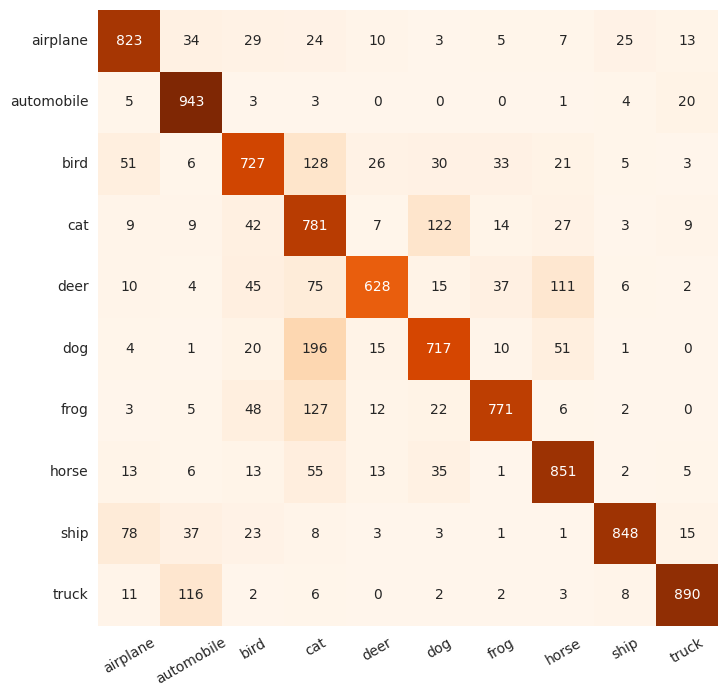

In [ ]:
conf_mat = confusion_matrix(
    y_true=actual_labels,
    y_pred=predicted_labels
)

plt.figure(figsize=(8, 8))
sns.heatmap(
    conf_mat,
    cmap='Oranges',
    annot=True,
    cbar=False,
    fmt='.3g'
);


xlocs, _ = plt.xticks()
plt.xticks(
    ticks=xlocs,
    labels=transformed_dataset['train'].class_to_idx.keys(),
    rotation=30
);

ylocs, _ = plt.yticks()
plt.yticks(
    ticks=ylocs,
    labels=transformed_dataset['train'].class_to_idx.keys(),
    rotation=360
);

In [ ]:
preds, _ = predict(trained_model,'test')

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [ ]:
preds[:10]

[tensor(3, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(2, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(5, device='cuda:0'),
 tensor(0, device='cuda:0'),
 tensor(3, device='cuda:0'),
 tensor(4, device='cuda:0'),
 tensor(6, device='cuda:0')]

In [ ]:
preds = convert_to_idx(preds)
preds[:10]

[3, 3, 0, 2, 3, 5, 0, 3, 4, 6]

In [ ]:
def idx_to_class(preds):
    li = []
    map_preds = {0 : 'airplane',
                 1 : 'automobile',
                 2 : 'bird',
                 3 : 'cat',
                 4 : 'deer',
                 5 : 'dog',
                 6 : 'frog',
                 7 : 'horse',
                 8 : 'ship',
                 9 : 'truck'
                }
    for pred in preds:
        if pred in map_preds.keys():
            li.append(map_preds[pred])
    return li

In [ ]:
preds = idx_to_class(preds)
preds[:10]

['cat',
 'cat',
 'airplane',
 'bird',
 'cat',
 'dog',
 'airplane',
 'cat',
 'deer',
 'frog']

In [ ]:
length = len(preds)
length

300000

#6. Preprocessing and Training ResNet50

In [ ]:
batch_tfms = [*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
dls=ImageDataLoaders.from_folder(
    path=paths['train'],
    train='train',
    valid='eval',
    item_tfms=Resize(224),
    batch_tfms=batch_tfms,bs=64
)
learn = vision_learner(dls, resnet50, metrics=accuracy, wd=0.01)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 250MB/s] 


SuggestedLRs(valley=0.0006918309954926372)

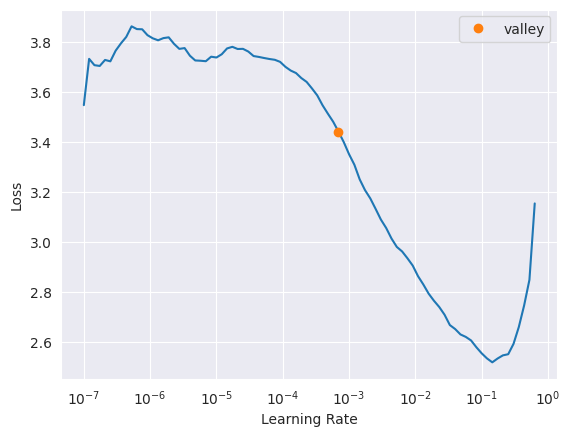

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.518369,0.317725,0.896900,02:54
1,0.305765,0.182394,0.940100,02:54
2,0.237341,0.155908,0.946700,02:54


SuggestedLRs(valley=1.2022644114040304e-05)

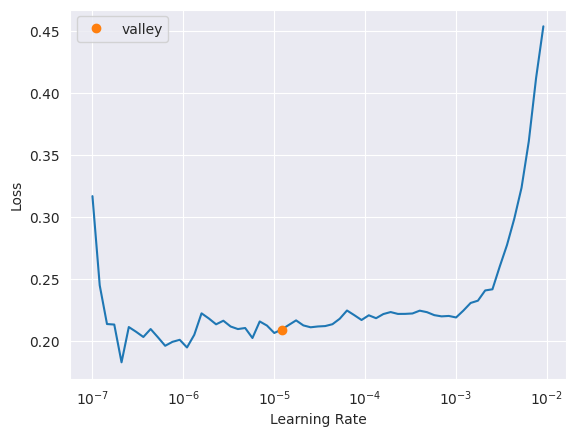

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-6,3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.164135,0.131358,0.955100,03:45
1,0.131702,0.125877,0.958200,03:44
2,0.107077,0.117423,0.959300,03:44
3,0.099460,0.116635,0.960200,03:45
4,0.091249,0.117930,0.960300,03:45


SuggestedLRs(valley=9.999999747378752e-06)

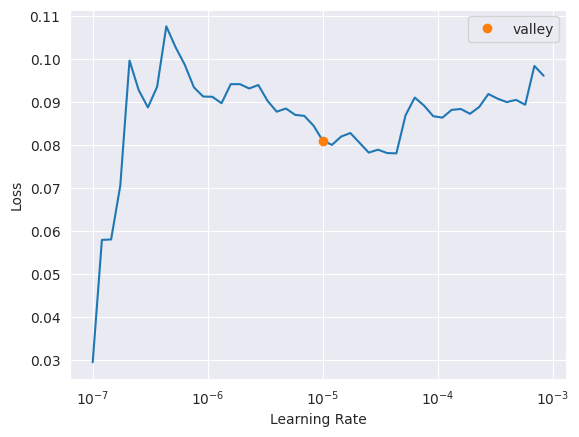

In [ ]:
learn.unfreeze()
learn.lr_find()

#7. Predicting Labels using ResNet50

In [ ]:
test_img_paths = [os.path.join(paths['test'], file) for file in os.listdir(paths['test'])]
test_dl = learn.dls.test_dl(test_img_paths)
class_score, y =learn.get_preds(dl=test_dl)
class_score = np.argmax(class_score, axis=1)
classScore = class_score.tolist()

In [ ]:
learn.dls.vocab

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
predicted_labels = idx_to_class(classScore)
print(classScore[:10])
print(predicted_labels[:10])

[6, 0, 1, 3, 2, 8, 5, 5, 1, 6]
['frog', 'airplane', 'automobile', 'cat', 'bird', 'ship', 'dog', 'dog', 'automobile', 'frog']


In [ ]:
ImageId = [ (''.join(filter(str.isdigit, name))) for name in os.listdir(paths['test'])]
submission_df = pd.DataFrame({
    'id' : ImageId,
    'label' : predicted_labels
})
submission_df.head()
submission_df.to_csv('/kaggle/working/submission_df.csv', index=False)

#8. Conclusion

<div style="color:black;
           display:fill;
           border-radius:5px;
           font-size:150%;
           font-family:Verdana;
           letter-spacing:0.5px;
           text-align:left">
    
Using ResNet50, we can acheive a reliable and accurate image classifier with respect to VGG16 because it is a modern naural network and avoid vanishing gradient using skip connections commonly encountered in deep neural networks.<br>

<br>If you find this notebook valuable, your support by giving an upvote would be greatly appreciated. THANK YOU :)
      
</div>
